In [2]:
import requests
import json
import os
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from datetime import datetime, timedelta
import logging 
import pprint

# Fetching data from data.gov.sg and creating main current precipitation dataframe

In [ ]:
url = 'https://api-open.data.gov.sg/v2/real-time/api/rainfall'
response = requests.get(url)
rawdata = response.json()
value = rawdata['data']['readings'][0]['data']
timestamp = rawdata['data']['readings'][0]['timestamp']
metadata = rawdata['data']['stations']


StationList = [dict['stationId'] for dict in value]
ValueList = [dict['value'] for dict in value]
timestampList = [timestamp for dict in value]

data = {'timestamp': timestampList, 'stations': StationList, 'values': ValueList}
CurrentPrecipDF = pd.DataFrame(data=data)
CurrentPrecipDF


# Creating Metadata Dataframe

In [ ]:
def MetadataDF_Constructor(metadata: list):
    data = {'id': [], 'name': [], 'latitude': [], 'longitude': []}
    for dict in metadata:
        data['id'].append(dict['id'])
        data['name'].append(dict['name'])
        data['latitude'].append(dict['location']['latitude'])
        data['longitude'].append(dict['location']['longitude'])
    return pd.DataFrame(data=data)

MetaData = MetadataDF_Constructor(metadata)

MetaData

# Adding coordinate information to main current precipitation dataframe

In [19]:
new_df = pd.DataFrame(columns=['timestamp', 'stations', 'values', 'latitude', 'longitude'])
for precipmetadf_row in MetaData.iterrows():
    for precipdf_row in CurrentPrecipDF.iterrows():
        if precipmetadf_row[1]['id'] == precipdf_row[1]['stations']:
            latlongseries = pd.Series(data=[precipmetadf_row[1]['latitude'], precipmetadf_row[1]['longitude']], index=['latitude', 'longitude'])
            precipdf_row = pd.concat([precipdf_row[1], latlongseries])
            new_df = pd.concat([new_df, pd.DataFrame(precipdf_row).transpose()])
precipmaindf = new_df
# precipmaindf['geometry'] = precipmaindf.apply(lambda x: Point((x['latitude'], x['longitude'])), axis=1)

CurrentPrecipDF = new_df

MovieWriter imagemagick unavailable; using Pillow instead.


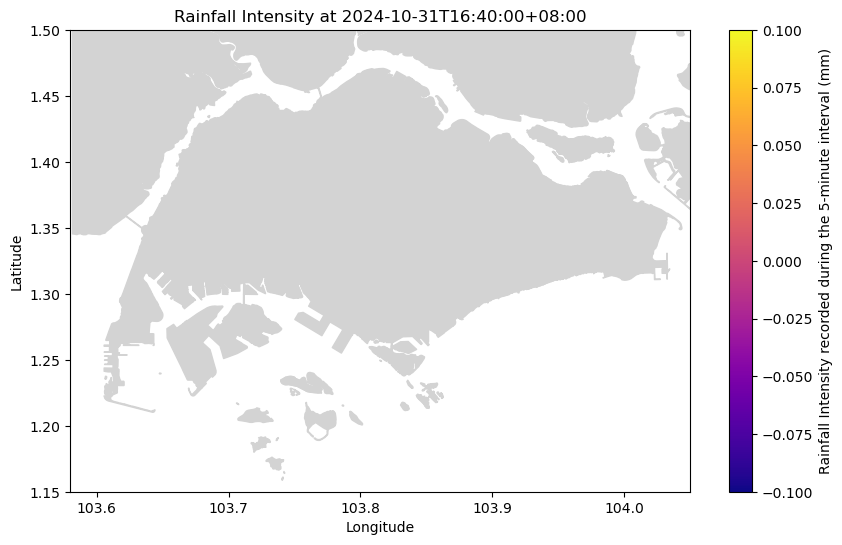

In [21]:
## Plotting heatmap of precipitation during 1900H to 2000H period and animating the propagation of precipitation
# Center the map over Singapore
map_center = [1.3521, 103.8198]  # Approximate coordinates of Singapore

# Create a Folium map
m = folium.Map(location=map_center, zoom_start=12)

# Prepare data for HeatMap
heat_data = [[row['latitude'], row['longitude'], row['values']] for index, row in CurrentPrecipDF.iterrows()]

# Add heatmap to the map
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file
m.save("singapore_rainfall_intensity.html")
CurrentPrecipDF['values'] = CurrentPrecipDF['values'].astype(float)  # Ensure the column is float type

# Reading of the SG geojson file
singapore_map = gpd.read_file('NationalMapPolygonKML.geojson')

# Prepare the data for the heatmap animation
time_groups = CurrentPrecipDF.groupby('timestamp')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set color normalization based on the min and max rainfall intensity in your dataset
norm = Normalize(vmin=CurrentPrecipDF['values'].min(), vmax=CurrentPrecipDF['values'].max())
cmap = plt.cm.plasma  # Other colormaps that can be tried are 'viridis' or 'coolwarm'

# Create a ScalarMappable object for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # We set an empty array since we will pass data to the colorbar later

# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Rainfall Intensity recorded during the 5-minute interval (mm)")

# Define the update function for each frame
def update(frame):
    ax.clear()  # Clear the axis for the new frame
    
    timestamp, time_slice = frame
    
    # Plot the Singapore map
    singapore_map.plot(ax=ax, color='lightgray', edgecolor='lightgray')
    
    # Create the scatter plot for the current frame
    sc = ax.scatter(
        time_slice['longitude'], 
        time_slice['latitude'], 
        c=time_slice['values'],  # Color based on rainfall intensity
        s=time_slice['values'] * 20,  # Adjust size of the dots
        cmap=cmap, 
        norm=norm,  # Use the normalization set earlier
        alpha=0.7
    )
    
    # Set the title with the current timestamp
    ax.set_title(f"Rainfall Intensity at {timestamp}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim([103.58, 104.05])
    ax.set_ylim([1.15, 1.50])
    
    # The colorbar remains fixed with the same range across all frames

# Prepare the frames (grouped by timestamp)
frames = [(timestamp, time_slice) for timestamp, time_slice in time_groups]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)

# Save the animation as a gif or mp4
ani.save("rainfall_animation_with_colorbar.gif", writer='imagemagick', fps=1)

# To save as mp4
# ani.save("rainfall_animation_with_colorbar.mp4", writer='ffmpeg', fps=2)

plt.show()

In [8]:
data = pd.read_csv('frequencydata/data.csv', on_bad_lines='warn')
forecast = pd.read_csv('CurrentForecast.csv')
forecast[forecast['area'] == 'Tampines']['forecast'].iloc[0]

'Partly Cloudy (Day)'